In [1]:
! which python

/home/mrj/anaconda3/envs/yolov3-tf2-cpu/bin/python


In [2]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS

import cv2
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt


from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs, draw_detect_bbox

In [8]:
CLASSES = '/home/mrj/Sundry/resume_labels/resume_classes_v2.names'
# CLASSES = "/home/mrj/Code/OpenSourceProject/yolov3-tf2/data/coco.names"

WEIGHTS = '/home/mrj/Sundry/resume_labels/yolo_resume.tf'
# WEIGHTS = "/home/mrj/Code/OpenSourceProject/yolov3-tf2/checkpoints/yolov3_train_40.tf"
# WEIGHTS = "/home/mrj/Code/OpenSourceProject/yolov3-tf2/checkpoints/yolov3.tf"

IS_TINY = False

SIZE = 416

DETECT_IMAGE = '/home/mrj/Sundry/Bello/resume_img/origin_img/00074.jpg'
# DETECT_IMAGE = '/home/mrj/Sundry/Bello/resume_img/test_img/00163.jpg'
# DETECT_IMAGE = "/home/mrj/Documents/Work/Bello/ResumeExample/03.jpg"

TFREORD = None

OUTPUT = '/home/mrj/Sundry/resume_labels/detect_output_test.jpg'

NUM_CLASSES = 2

SHOW_DETECT_BOUNDING_BOX = True

SHOW = True


app._run_init(['yolov3'], app.parse_flags_with_usage)

['yolov3']

I0225 17:31:47.022603 139853081352000 <ipython-input-9-1905ee30c9ac>:17] weights loaded
I0225 17:31:47.023856 139853081352000 <ipython-input-9-1905ee30c9ac>:20] classes loaded
I0225 17:31:47.421486 139853081352000 <ipython-input-9-1905ee30c9ac>:37] time: 0.38567185401916504
I0225 17:31:47.422582 139853081352000 <ipython-input-9-1905ee30c9ac>:39] detections:
I0225 17:31:47.425560 139853081352000 <ipython-input-9-1905ee30c9ac>:43] 	text, 0.9063806533813477, [0.34892902 0.22968656 0.9873816  0.33540976]
I0225 17:31:47.428359 139853081352000 <ipython-input-9-1905ee30c9ac>:43] 	text, 0.8349034786224365, [0.34256163 0.38686317 1.         0.46066344]
I0225 17:31:47.432468 139853081352000 <ipython-input-9-1905ee30c9ac>:43] 	text, 0.8131670355796814, [0.01204661 0.6910119  0.37970605 0.8860105 ]
I0225 17:31:47.438531 139853081352000 <ipython-input-9-1905ee30c9ac>:43] 	text, 0.7992439270019531, [0.30581215 0.60982364 1.         0.69063956]
I0225 17:31:47.440614 139853081352000 <ipython-input-9-1

<Figure size 1440x1440 with 0 Axes>

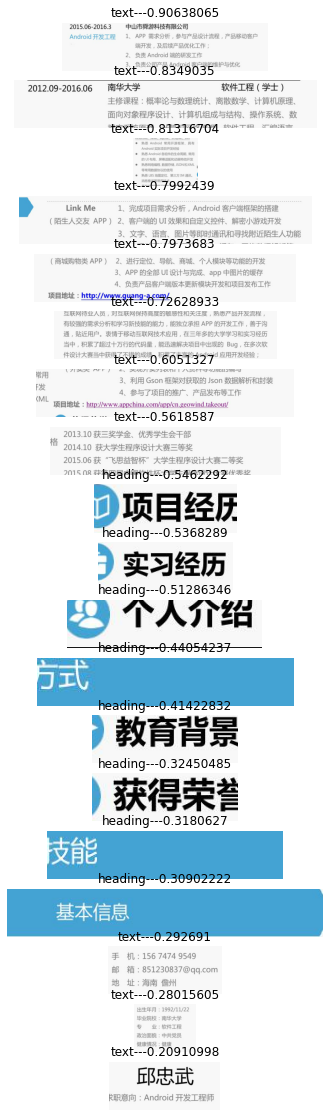

In [9]:
%matplotlib inline

plt.figure(figsize=(20, 20))


def detect():
    # physical_devices = tf.config.experimental.list_physical_devices('GPU')
    # for physical_device in physical_devices:
    #     tf.config.experimental.set_memory_growth(physical_device, True)

    if IS_TINY:
        yolo = YoloV3Tiny(classes=NUM_CLASSES)
    else:
        yolo = YoloV3(classes=NUM_CLASSES)

    yolo.load_weights(WEIGHTS).expect_partial()
    logging.info('weights loaded')

    class_names = [c.strip() for c in open(CLASSES).readlines()]
    logging.info('classes loaded')

    if TFREORD:
        dataset = load_tfrecord_dataset(
            TFREORD, CLASSES, SIZE)
        dataset = dataset.shuffle(512)
        img_raw, _label = next(iter(dataset.take(1)))
    else:
        img_raw = tf.image.decode_image(
            open(DETECT_IMAGE, 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, SIZE)

    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    logging.info('time: {}'.format(t2 - t1))

    logging.info('detections:')
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                           np.array(scores[0][i]),
                                           np.array(boxes[0][i])))

    if SHOW_DETECT_BOUNDING_BOX:
        draw_detect_bbox(img_raw.numpy(), (boxes, scores, classes, nums), class_names)
        return

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

    if SHOW:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        return

    cv2.imwrite(FLAGS.output, img)
    logging.info('output saved to: {}'.format(FLAGS.output))

    

detect()